In [1]:
import numpy as np
import pandas as pd
import glob
import scipy as sc
import matplotlib.pylab as plt
%matplotlib inline
import inspect
import microfit.database as db
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
import warnings
warnings.filterwarnings(action='once')
from scipy.signal import triang
from scipy.signal import lfilter
from scipy.signal import gaussian
from scipy.stats import beta
import scipy.stats as ss
from scipy.stats import lognorm
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

<Figure size 640x480 with 0 Axes>

In [2]:
plt.style.use('../manuscript.mplstyle')
plt.rcParams['figure.figsize']

[8.0, 5.5]

In [3]:
show = True

In [4]:
xlsx = '../index_2018_02_PRF_data.xlsx'
df = pd.read_excel(xlsx)

C:\Users\Navid\Miniconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [5]:
cases = np.unique(df.case)
cases = ['2020_02_27_nheptane_130.34psig_12.37O2_1mm']
cases

['2020_02_27_nheptane_130.34psig_12.37O2_1mm']

In [6]:
ix = df.case.isin(cases)
rp = db.Database(df[ix],verbosity=2)

In [7]:
seq2 = rp.find_sequence_by('case',v=4, phi =1)
seq2

{'2020_02_27_nheptane_130.34psig_12.37O2_1mm': 3}

In [8]:
fft2 = rp.perform_analyses(seq2, camera=2, align=False)
ch = 'f430x10h'
h = cases[0]
ggg = fft2[h]
#print(fft2,ggg)
print(ggg)
images = {'difference': ggg.without_filament[ch]}
hdr2 = rp.get_entries(seq2,'hdr2')
print(fft2),print(ggg),print(ggg.without_filament[ch]);
type(images['difference'])

Case: 2020_02_27_nheptane_130.34psig_12.37O2_1mm (C:\Users\Navid\1Notebooks_master\fuels\2020_02_27_nheptane_130.34psig_12.37O2_1mm)
 * perform_analysis -> nheptane_d76.2_v4.0_phi1.00_ps130.34_pa130.340000_pref5.930000_(ve160_phie0.65)
    <load_raw> ... generate HDR calibration image: cube0_raw2.tif
    <load_raw> ... generate HDR image: nheptane_d76.2_v4.0_phi1.00_ps130.34_pa130.340000_pref5.930000_(ve160_phie0.65)_raw2.tif
    <perform_analysis> ... creating new `Fourier` object
{'2020_02_27_nheptane_130.34psig_12.37O2_1mm': <microfit.analysis.Fourier object at 0x0000014035300F48>}


C:\Users\Navid\Miniconda3\lib\site-packages\microfit\analysis.py:480: PendingDeprecationWarning: ``without_filament`` retained for debugging purposes
  PendingDeprecationWarning)
C:\Users\Navid\Miniconda3\lib\site-packages\microfit\analysis.py:470: PendingDeprecationWarning: ``synthetic_filament`` retained for debugging purposes
  PendingDeprecationWarning)


[[ 0.00020246 -0.02129479 -0.00982654 ... -0.00303835  0.01939205
   0.01915886]
 [ 0.01369591  0.01054321 -0.0222096  ... -0.02157402  0.00110176
  -0.01257007]
 [-0.03140041  0.02269916  0.01711871 ...  0.00513362  0.02655018
  -0.01372627]
 ...
 [ 0.00510077  0.00993341  0.07111678 ... -0.0096386   0.0230534
   0.02172194]
 [ 0.02512061  0.07055482 -0.01084553 ... -0.00460568  0.00717936
   0.00100283]
 [ 0.00250316  0.01920761 -0.02003638 ... -0.00887564  0.01418295
  -0.00310416]]


numpy.ndarray

In [9]:
frames1 = rp.extract_flames(seq2,camera=2)

Case: 2020_02_27_nheptane_130.34psig_12.37O2_1mm (C:\Users\Navid\1Notebooks_master\fuels\2020_02_27_nheptane_130.34psig_12.37O2_1mm)
 * extract_flame -> nheptane_d76.2_v4.0_phi1.00_ps130.34_pa130.340000_pref5.930000_(ve160_phie0.65)
    <load_raw> ... generate HDR calibration image: cube0_raw1.tif
    <load_raw> ... generate HDR image: nheptane_d76.2_v4.0_phi1.00_ps130.34_pa130.340000_pref5.930000_(ve160_phie0.65)_raw1.tif
    <perform_analysis> ... creating new `Fourier` object
rejecting apparent diameter: 68.992
0.4921875 0.4921875
rejecting apparent diameter: 68.992
0.4921875 0.4921875
    <extract_filament> ... extracting `Fourier` filament
    <extract_temperature> ... creating `PyroFrame` object
    <perform_analysis> ... returning buffered `Fourier` object
    <extract_filament> ... extracting `Fourier` filament
    <extract_flame> ... creating `FlameFrame` object


# Functions

In [34]:
def mask_plot(DIF):
    #DIF is number of pixels within the tube (here 17 pixels = IDb-IDt)
    msk = np.sin(np.pi*(np.arange(DIF)) / DIF)
    msk1 = triang(DIF)
    msk2 = gaussian(DIF,std= 3)
    msk3 = skewnormsk(DIF, 9)
    msk4 = lognormmask(DIF, 0.6)
    p = np.poly1d([-1,0,0])
    msk5 = np.asarray([p(i)+1 for i in np.arange(-1,1,(1-(-1))/DIF)])
    rr = np.arange(DIF)
    return msk,msk1,msk2,msk3,msk4,msk5,rr

In [35]:
def skewnormsk(b,a):
    y = np.linspace(ss.skewnorm.ppf(0.001, a),
                ss.skewnorm.ppf(0.99, a), b)
    x = ss.skewnorm.pdf(y, a)
    xx = (x-np.amin(x))/(np.amax(x)-np.amin(x))
    xx1 = xx[::-1]
    return xx1

In [36]:
def lognormmask(b,a):
    y = np.linspace(lognorm.ppf(0.001, a),
                lognorm.ppf(0.99, a), b)
    x = lognorm.pdf(y, a)
    xx = (x-np.amin(x))/(np.amax(x)-np.amin(x))
    xx1 = xx[::-1]
    return xx1

# Procedure

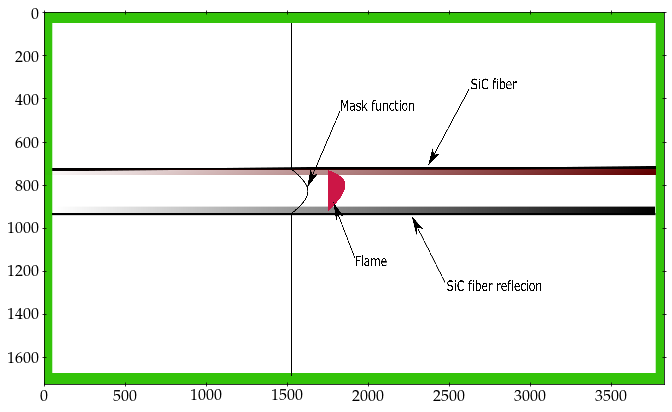

In [37]:
fig = plt.figure(figsize=(10,6))
img = mpimg.imread('rect4485.png')
plt.imshow(img,aspect='auto')
plt.show()

# Mask Plot

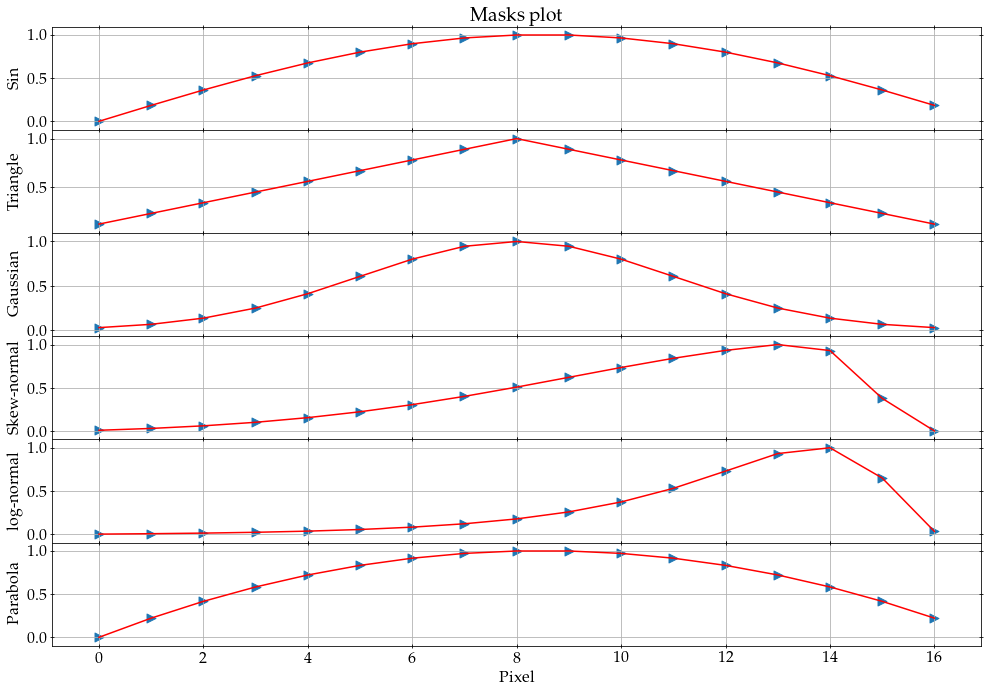

In [38]:
title=['Sin','Triangle','Gaussian','Skew-normal','log-normal','Parabola','Original']
fig,ax = plt.subplots(len(title)-1,1,sharex=True)
fig.set_size_inches(15,10)
for i in range(len(title)-1):
    ax[i].scatter(mask_plot(17)[-1],mask_plot(17)[i],s=80,marker='>')
    ax[i].plot(mask_plot(17)[-1],mask_plot(17)[i],'r')
    ax[i].grid(which='major')
    ax[i].grid(which='minor', linewidth=1)
    ax[i].set_ylabel(title[i])
    ax[-1].set_xlabel("Pixel%number")
    ax[0].set_title('Masks plot')

# Mask Functions

In [15]:
images = {'difference': ggg.without_filament[ch]}
def mask(Channel, Image,X):
    ys = Channel.pos.tube_outline(X)
    IDt = int(np.mean(ys['IDt']))
    IDb = int(np.mean(ys['IDb']))
    DIF = IDb-IDt
    msk = np.sin(np.pi*(np.arange(IDt, IDb) - IDt) / DIF)
    msk3 = triang(DIF)
    msk4 = gaussian(DIF,std= 3)
    msk5 = skewnormsk(DIF, 9)
    msk6 = lognormmask(DIF, 0.7)
    ##########################
    p = np.poly1d([-1,0,0])
    msk7 = np.asarray([p(i)+1 for i in np.arange(-1,1,(1-(-1))/DIF)])
    ######################Parabola -X^2+1
    f = Image.copy()
    e = Image.copy()
    m = Image.copy()
    g = Image.copy()
    w = Image.copy()
    z = Image.copy()
    f[IDt:IDb, :] = np.repeat(msk[: ,np.newaxis], f.shape[1], axis=1)
    e[IDt:IDb, :] = np.repeat(msk3[: ,np.newaxis], e.shape[1], axis=1)
    m[IDt:IDb, :] = np.repeat(msk4[: ,np.newaxis], m.shape[1], axis=1)
    g[IDt:IDb, :] = np.repeat(msk5[: ,np.newaxis], g.shape[1], axis=1)
    w[IDt:IDb, :] = np.repeat(msk6[: ,np.newaxis], w.shape[1], axis=1)
    z[IDt:IDb, :] = np.repeat(msk7[: ,np.newaxis], z.shape[1], axis=1)
    f[IDb:,:]= f[:IDt,:] = 0
    e[IDb:,:]= e[:IDt,:] = 0
    m[IDb:,:]= m[:IDt,:] = 0
    g[IDb:,:]= g[:IDt,:] = 0
    w[IDb:,:]= w[:IDt,:] = 0
    z[IDb:,:]= z[:IDt,:] = 0
    new = np.multiply(f,Image)
    new3 = np.multiply(e,Image)
    new4 = np.multiply(m,Image)
    new5 = np.multiply(g,Image)
    new2 = Image.copy()
    new6 = np.multiply(w,Image)
    new7 = np.multiply(z,Image)
    return new,new3,new4,new5,new6,new7,new2

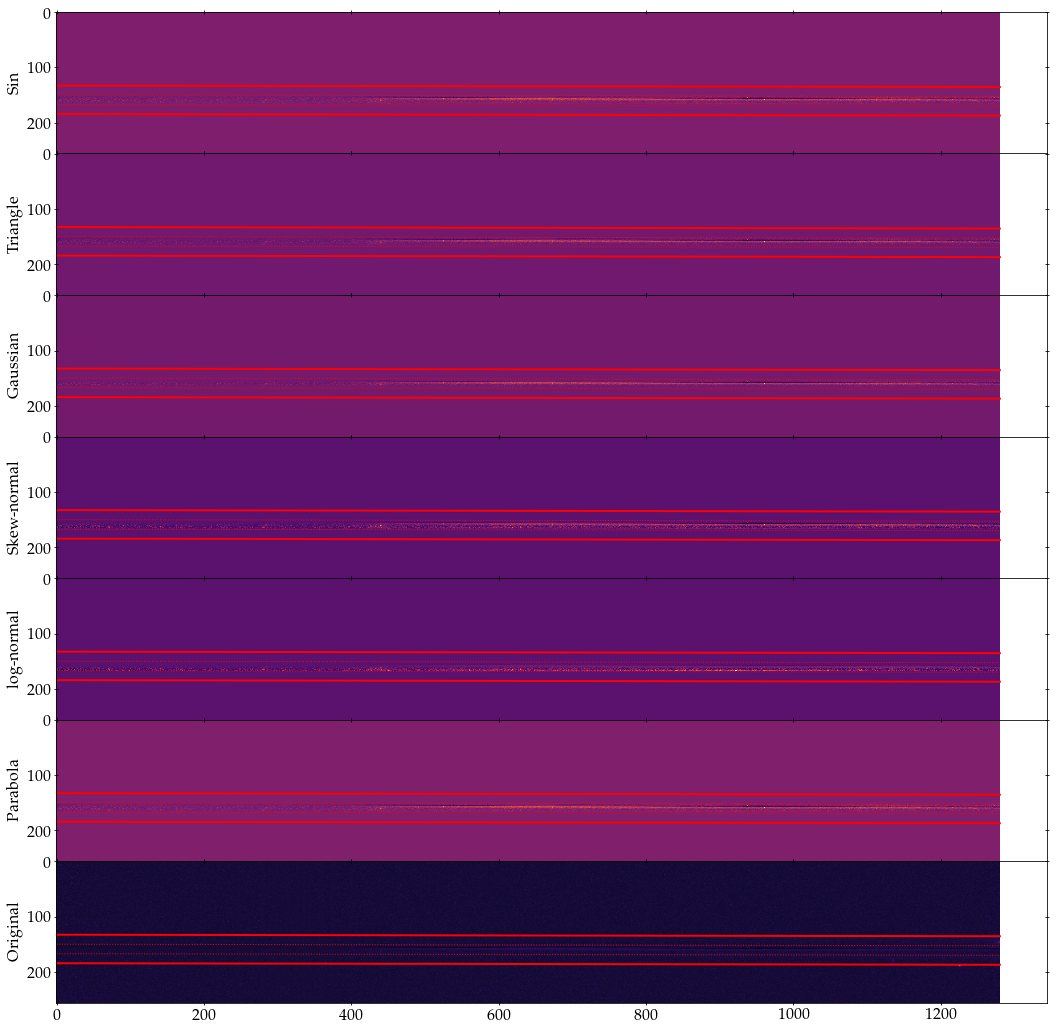

In [16]:
xs = np.array([0,1280])
ys = hdr2[h].pos.tube_outline(xs)
title=['Sin','Triangle','Gaussian','Skew-normal','log-normal','Parabola','Original']
fig, ax = plt.subplots(len(title), 1, sharex=True, sharey=True, figsize=(16,16))
for i in range(len(title)):
    ax[i].imshow(mask(hdr2[h],images['difference'],xs)[i], aspect='auto')
    ax[i].set_ylabel(title[i])
    for pos in ['ODt','ODb']:
        ax[i].plot(xs,ys[pos],'r-',linewidth=2)
    for pos in ['IDt','IDb']:
        ax[i].plot(xs,ys[pos],'r:',linewidth=1)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


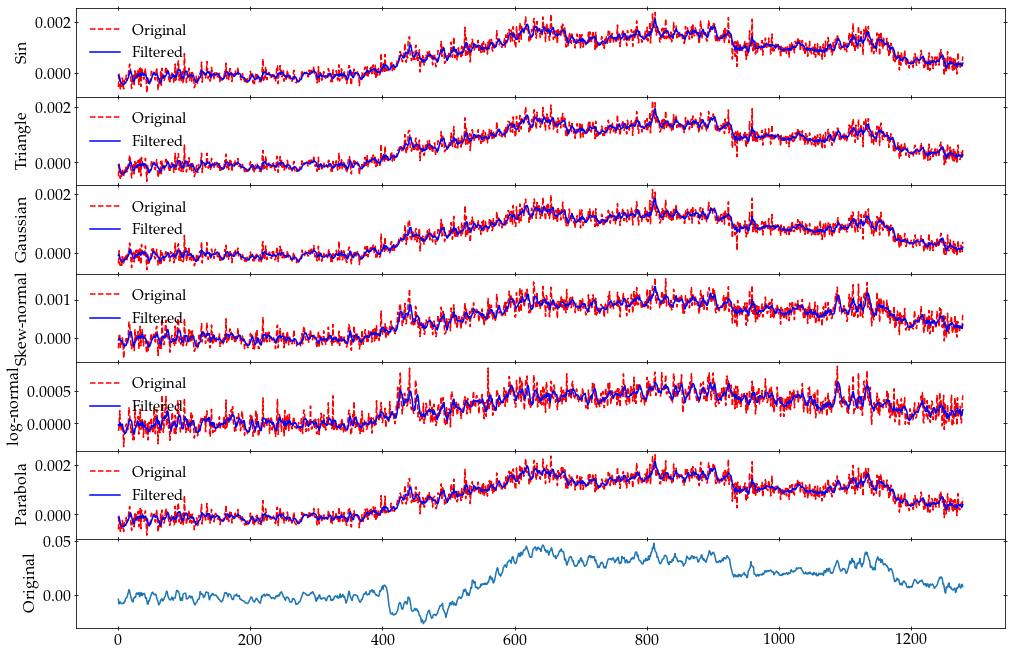

In [17]:
title=['Sin','Triangle','Gaussian','Skew-normal','log-normal','Parabola','Original']
fig,ax = plt.subplots(len(title),sharex=True)
fig.set_size_inches(15,10)
n = 5  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
x_s = np.arange(1280)
for i in range(len(title)):
    if i != len(title)-1:
        sig= mask(hdr2[h],images['difference'],xs)[i].mean(axis=0)
        yy = lfilter(b,a,sig)   
        ax[i].plot(x_s,sig,'--r',label='Original')
        ax[i].plot(x_s,yy,'b',label='Filtered')
        ax[i].set_ylabel(title[i])
        ax[i].legend()
    else:
        pci = frames1[str(h)]
        ax[i].plot(x_s,pci.data['f430x10h'])
        ax[i].set_ylabel(title[i])

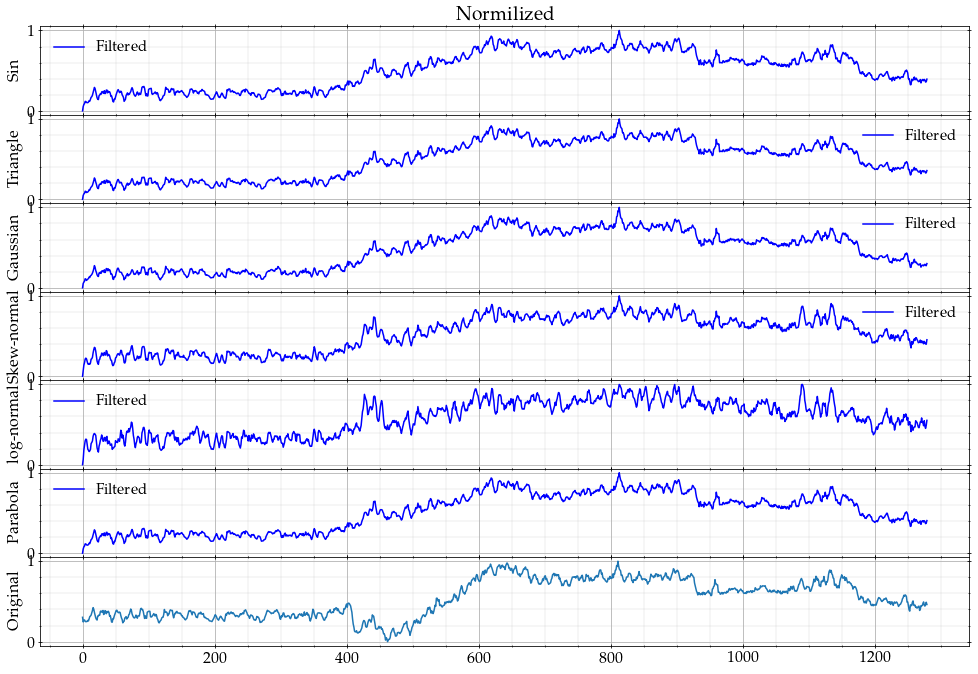

In [18]:
title=['Sin','Triangle','Gaussian','Skew-normal','log-normal','Parabola','Original']
fig,ax = plt.subplots(len(title),1,sharex=True)
fig.set_size_inches(15,10)
n = 5  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
x_s = np.arange(1280)
kernel = np.ones(8,np.uint8)
for i in range(len(title)):
    if i != len(title)-1:
        sig= mask(hdr2[h],images['difference'],xs)[i].mean(axis=0)
        max = np.amax(sig)
        min = np.amin(sig)
        sig[:] = [(x - min)/(max-min) for x in sig]
        yy = lfilter(b,a,sig) 
        yy1 = np.asarray([(yy[i] - np.amin(yy))/(np.amax(yy)-np.amin(yy)) for i in range(len(yy))])
        ax[i].plot(x_s,yy1,'b',label='Filtered')
        ax[i].set_ylabel(title[i])
        ax[i].legend()
        ax[0].set_title('Normilized')
        ax[i].minorticks_on()
        ax[i].grid(which='major')
        ax[i].grid(which='minor', linewidth=0.2)
    else:
        pci = frames1[str(h)]
        sig = pci.data['f430x10h']
        max1 = np.amax(sig)
        min1 = np.amin(sig)
        sig[:] = [(x - min1)/(max1-min1) for x in sig]
        p = pci.p_flame
        v_flame = (pci.v_flame - min1)/(max1-min1)
        ax[i].plot(x_s,sig)
        #ax[i].plot(p,v_flame,'o')
        ax[i].set_ylabel(title[i])
        ax[i].minorticks_on()
        ax[i].grid(which='major')
        ax[i].grid(which='minor', linewidth=0.2)